# Задачи

# Алгоритм

### Импорты

In [140]:
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from collections import Counter
from scipy.optimize import curve_fit

### Двойственный алгоритм

In [25]:
class Task:
    """
    A class for a single task.
    
    Init parameters:
        rMin, rMax -- recievement time limits
        pMin, pMax -- process time limits
        dMin, dMax -- due date limits
        
    For each task the recievement time, process time and due date
    are calculated randomly (uniform distribution) between given limits.
    Default limit values are in the code below.
    
    Additional parameters:
        phi -- the loss function for this particular task.
        By default returns its argument without changing it
    """
    r = 0
    p = 0
    d = 0
    phi = None
            
    def gen_r(self, rMin, rMax):
        self.r = int(random.uniform(rMin, rMax))
        
    def gen_p(self, pMin, pMax):
        self.p = int(random.uniform(pMin, pMax))
        
    def gen_d(self, dMin, dMax):
        self.d = int(random.uniform(dMin, dMax))
    
    def __init__(self,
                 NNTS=False,
                 rMin = 1,
                 rMax = 100,
                 pMin = 1,
                 pMax = 100,
                 dMin = 1,
                 dMax = 200,
                 dDelta = 100,
                 **kwargs):
        self.gen_r(rMin, rMax)
        self.gen_p(pMin, pMax)
        if NNTS:
            dMin = self.r + self.p
            dMax = dMin + dDelta
        self.gen_d(dMin, dMax)
        self.phi = kwargs.get('phi', lambda x: x)
        
    def show(self):
        print("r =", self.r, "| p =", self.p, "| d =", self.d)
        
    @staticmethod
    def show_all(tasks):
        """
        Show r, p, d for each task from the 'tasks' list 
        """
        print(" r", "p", "d", sep=' | ', end='\n\n')
        for task in tasks:
            print(task.r, task.p, task.d, sep=' | ')
    
    @staticmethod
    def generate_multiple(nTasks, NNTS=False, **kwargs):
        """
        Generate multiple tasks.
        
        Parameters:
            nTasks - the number of tasks to generate
            NNTS - (bool) whether to use NNTS or not
        
        **kwargs parameters (see Task class docstring):
            rMin, rMax -- recievement time limits
            pMin, pMax -- process time limits
            dMin, dMax -- due date limits
            phi -- the loss function for this particular task.
            By default returns its argument without changing it
        """
        return list(Task(NNTS=NNTS, **kwargs) for i in range(nTasks))
    
def C(pi, j=None):
    """
    Returns the completion time of task number j in schedule pi
    """
    t = 0
    for task in pi[:j]:
        if t < task.r:
            t = task.r
        t += task.p
    return t

def phi(pi, j=None):
    """
    Returns the phi value of task number j in schedule pi.
    Uses the task`s own phi function
    """
    t = j or 0
    return pi[t].phi(C(pi, j))

def dual_modified(tasks):
    """
    Returns optimal schedule, the k value and max value of phi
    """
    
    def create_B(tasks, k):
        return tasks.copy()[k+1:]
    
    def argmin(tasks):
        return min(enumerate(tasks), key=lambda x: x[1].r)[0]
    
    def create_pi_k(sortedTasks, k, i_l):
        pi_k = sortedTasks.copy()
        task_l = pi_k.pop(i_l)
        if i_l < k:
            k -= 1
        task_k = pi_k.pop(k)
        return [task_l] + pi_k + [task_k]
    
    minPhi = phi(tasks)
    minK = -1
    bestPi = tasks
    
    sortedTasks = sorted(tasks, key=lambda x: x.r)
    for k, task in enumerate(sortedTasks):
        B = create_B(sortedTasks, k)
        #print(type(tasks))
        availableTasks = set(tasks) - set([task]) - set(B)
        if availableTasks != set([]):
            i_l = argmin(availableTasks)
            pi_k = create_pi_k(sortedTasks, k, i_l)
            phi_k = phi(pi_k)
            if phi_k < minPhi:
                minPhi = phi_k
                bestPi = pi_k
                minK = k
    return bestPi, minK, minPhi

## Алгоритм $L_{max}$

In [26]:
class Instance:
    N = []
    tau = None
    nu = None
    pi = None
    B = None
    
    def __init__(self, N, tau, pi, B):
        self.N = N
        self.tau = tau
        if N:
            self.nu = dual_modified(N)[2]
        else:
            self.nu = 0
        self.pi = pi
        self.B = B
        
    def get_available_jobs(self):
        return (set(self.N) - set(self.B)) - set(self.pi)
    

In [182]:
def find_best_instance(instanceList):
    return min(enumerate(instanceList), key=lambda x: x[1].nu)

def find_best_job(jobs):
    return min(enumerate(jobs), key=lambda x: x[1].d)

def compare(a, b):
    return Counter(a) == Counter(b)

def create_new_instances(prevInstance, bestJobIndex, bestJob):
    N1 = prevInstance.N[:]
    N1.pop(bestJobIndex)
    tau1 = max(bestJob.r, prevInstance.tau) + bestJob.p
    B1 = set()
    pi1 = prevInstance.pi + [bestJob]
    
    N2 = prevInstance.N
    tau2 = prevInstance.tau
    B2 = prevInstance.B | set([bestJob])
    pi2 = prevInstance.pi
    
    I1 = Instance(N1, tau1, pi1, B1)
    I2 = Instance(N2, tau2, pi2, B2)
    return [I1, I2]

def L_max(t):
    return max([C(t, j+1) - t[j].d for j in range(len(t))])

def main(N):
    counter = 0
    B = set()
    instanceList = [Instance(N, 0, [], set())]
    bestPi = N
    while instanceList:
        #print(len(instanceList))
        bestInstanceIndex, bestInstance = find_best_instance(instanceList)
        availableJobs = bestInstance.get_available_jobs()
        instanceList.pop(bestInstanceIndex)
        if availableJobs:
            bestJobIndex, bestJob = find_best_job(availableJobs)
            newInstances = create_new_instances(bestInstance, bestJobIndex, bestJob)
            counter += 1
            instanceList += newInstances
            pi1 = newInstances[0].pi
        if len(pi1) == len(N):
            if L_max(pi1) < L_max(bestPi):
                bestPi = pi1
        for index, item in enumerate(instanceList):
            if item.nu >= L_max(bestPi):
                instanceList.pop(index)
    return bestPi


In [34]:
class Timing:
    """
    Init parameters:
        nDims -- number of tasks in a schedule
        timings -- all timing results
        
    get_mean_time method calculates the mean value of all
    measured timings
    """
    nDims = 0
    timings = []
    
    def __init__(self, nDims):
        self.nDims = nDims
        self.timings = []
        
    def get_mean_time(self):
        return np.mean(self.timings)
    
    def add_time(self, time):
        self.timings.append(time)

In [102]:
def test(begin=3, end=11, step=1, nExamples=50):
    timings = []
    for i in range(begin, end, step):
        print("\r%s" % i, end='')
        timings.append(Timing(i))
        for j in range(nExamples):
            N = Task.generate_multiple(i, NNTS=True)
            timings[-1].add_time(main(N))
    return timings

In [103]:
timings = test()

10

In [156]:
x = []
y = []
for timing in timings:
    x.append(timing.nDims)
    y.append(np.mean(timing.timings))

In [232]:
def f(x, a, b):
    return a * np.exp(np.multiply(b, x))

In [246]:
popt, pcov = curve_fit(f, x, y)
perr = np.sqrt(np.diag(pcov))

In [247]:
perr

array([3.06140224e-05, 7.26341593e-02])

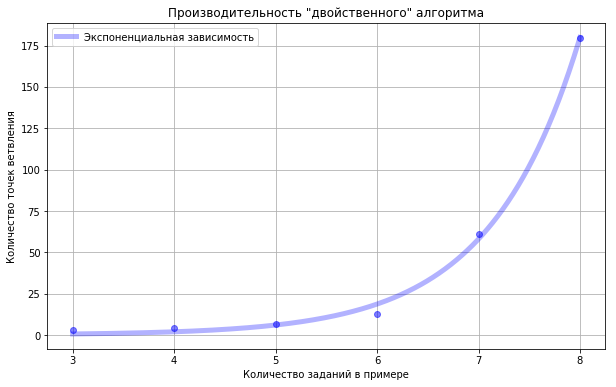

In [241]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.plot(x[:6], y[:6], 'bo', alpha=0.5)
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления")
xp = [i/100 for i in range(300, 801)]
ax.plot(xp, f(xp, *popt), color='b', linewidth=5, alpha=0.3, label="Экспоненциальная зависимость")
ax.legend()

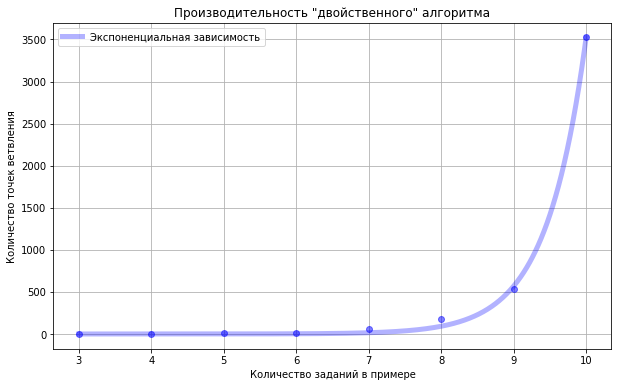

In [248]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.plot(x, y, 'bo', alpha=0.5)
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления")
xp = [i/100 for i in range(300, 1001)]
ax.plot(xp, f(xp, *popt), color='b', linewidth=5, alpha=0.3, label="Экспоненциальная зависимость")
ax.legend()

In [169]:
def bruteforce(N):
    best_pi = N
    best_L = L_max(N)
    p = list(permutations(N))
    for c, pi in enumerate(p):
        print("\r%f" % (c/len(p)), end='')
        if L_max(pi) < best_L:
            best_pi = pi
            best_L = L_max(pi)
    return best_L, best_pi